# EXEMPLES IV

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import xtrack as xt
import xplt

# EXAMPLE 1 - DBA cell

### Read MAD-X sequence from file (using cpymad)

In [2]:
from cpymad.madx import Madx
mad = Madx()
mad.option(echo=True)
name = "machine"
mad.call(file = 'Examp4/E_4_1.mdx')

mad.use(f'{name}')


### Import a line from a MAD-X sequence

In [3]:
line = xt.Line.from_madx_sequence(mad.sequence.machine,
                                  deferred_expressions=True, 
                                 )

Converting sequence "machine":   0%|          | 0/19 [00:00<?, ?it/s]

### Define the reference particule

In [4]:
line.particle_ref = xt.Particles(mass0=xt.ELECTRON_MASS_EV,
                            gamma0=mad.sequence.machine.beam.gamma,
                                )

In [5]:
line.build_tracker()

Found suitable prebuilt kernel `default_only_xtrack`.


### Machine Layout

In [6]:
sv = line.survey()

In [7]:
print("#######SURVEY######")
sv.rows[:].show()
print("#######TABLE WITH ALL ELEMENTS######")
line.get_table().rows[:].show()

#######SURVEY######
name                  X Y       Z     theta phi psi       s drift_length    angle tilt
machine$start         0 0       0         0   0   0       0            0        0    0
od00                  0 0       0         0   0   0       0            3        0    0
qq1_entry             0 0       3         0   0   0       3            0        0    0
qq1                   0 0       3         0   0   0       3          0.3        0    0
qq1_exit              0 0     3.3         0   0   0     3.3            0        0    0
od0                   0 0     3.3         0   0   0     3.3       0.5625        0    0
qq2_entry             0 0  3.8625         0   0   0  3.8625            0        0    0
qq2                   0 0  3.8625         0   0   0  3.8625          0.3        0    0
qq2_exit              0 0  4.1625         0   0   0  4.1625            0        0    0
od0:0                 0 0  4.1625         0   0   0  4.1625       0.5625        0    0
dain_entry            0

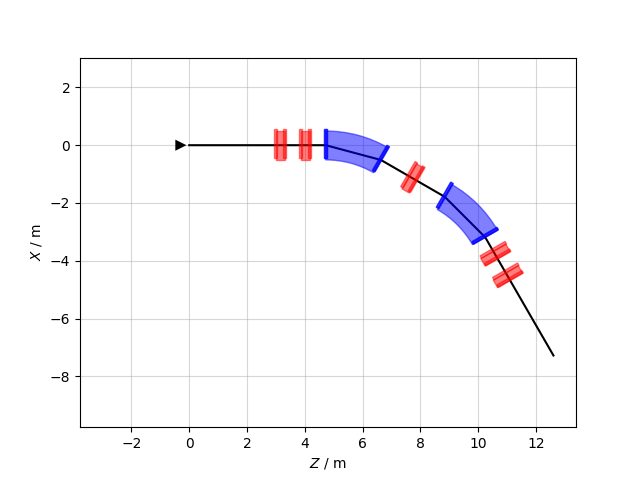

In [8]:
plot = xplt.FloorPlot(sv.rows[:], line, 
                boxes={  
                    ".q.": dict(color="red"), 
                    "dain": dict(color="blue"), 
                },
            )

### Twiss

In [9]:
tw = line.twiss(method='4d', 
                start = 'machine$start', 
                end = 'machine$end',
                betx=16.5833, alfx=-0.312271, 
                bety=13.2456, alfy=0.247252, 
                dx=2.92108e-16, dpx=-1.21141e-17,
               )


Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `only_xtrack_frozen_energy`.


In [10]:
tw[['betx', 'bety', 'dx']]

TwissTable: 38 rows, 4 cols
name             betx    bety          dx
machine$start 16.5833 13.2456           0
od00          16.5833 13.2456           0
qq1_entry     19.0526 12.4831           0
qq1           19.0526 12.4831           0
qq1_exit      16.3503 14.6674           0
od0           16.3503 14.6674           0
qq2_entry     7.79966  24.609           0
qq2           7.79966  24.609           0
qq2_exit      5.56585 26.2169           0
od0:0         5.56585 26.2169           0
dain_entry    3.88383 20.9611           0
dain_den      3.88383 20.9611           0
dain          3.88383 20.9611           0
dain_dex      1.13862 7.24906    0.511745
dain_exit     1.13862 7.24906    0.511745
od0:1         1.13862 7.24906    0.511745
od0:2         1.47976 4.79193    0.792995
qq0_entry     2.37838 2.94916     1.07425
qq0           2.37838 2.94916     1.07425
qq0_exit      2.37838 2.94916     1.07425
od0:3         2.37838 2.94916     1.07425
od0:4         1.47976 4.79194    0.792995
dain_e

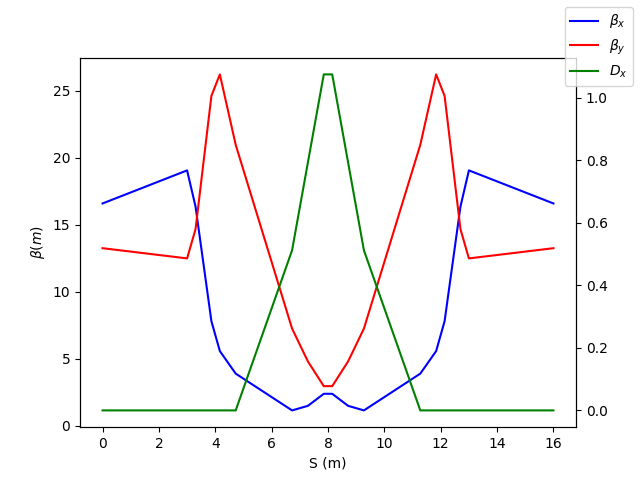

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tw['s'], tw['betx'], 'b', label = r'$\beta_x$')
ax.plot(tw['s'], tw['bety'], 'r', label = r'$\beta_y$')
ax.set(xlabel='S (m)', ylabel=r'$\beta (m)$')

ax2 = ax.twinx()

ax2.plot(tw['s'], tw['dx'], 'g', label = r'$D_x$')
fig.legend()

- Dispersion suppressed by a single quad flanked by a pair of bends. Additional mirror-symmetric pair of doublets provides hor/ver phase stability.
- The resulting lattice is mirror-symmetric rather than periodic  


## EXAMPLE 2 - Make the DBA cell periodic

- To get a periodic cell, use the doublets as matching quads to impose ax/y = 0 condition at both cell ends.


### Set the quadrupole strengths with variables

In [12]:
k1_init = line.element_refs['qq1'].k1._get_value() 
k2_init = line.element_refs['qq2'].k1._get_value() 

print("k1_init = ", k1_init)
print("k2_init = ", k2_init)
line.vars['kq_1'] = k1_init
line.vars['kq_2'] = k2_init
line.element_refs['qq1'].k1 = line.vars['kq_1']
line.element_refs['qq2'].k1 = line.vars['kq_2']
line.element_refs['qq1:0'].k1 = line.vars['kq_1']
line.element_refs['qq2:0'].k1 = line.vars['kq_2']

k1_init =  1.837999606
k2_init =  -1.942926968


### Match the alpha functions to zero at both cell ends

In [13]:
opt = line.match(
    method='4d',
    assert_within_tol=False,
    vary=[
        xt.VaryList(['kq_1', 'kq_2'], step=1e-6, tag='quad'),
    ],
    targets = [
        xt.TargetSet(alfx=0, alfy=0, at = 'machine$start', tol=1e-6, tag='alpha'),
        xt.TargetSet(alfx=0, alfy=0, at = 'machine$end', tol=1e-6, tag='alpha'),
    ])

Matching: model call n. 1               



In [14]:
opt.target_status()
opt.vary_status()

Target status:                          
id state tag   tol_met      residue  current_val target_val description                                 
 0 ON    alpha    True  1.81102e-12  1.81102e-12          0 ('alfx', 'machine$start'), val=0, tol=1e ...
 1 ON    alpha    True            0            0          0 ('alfy', 'machine$start'), val=0, tol=1e ...
 2 ON    alpha    True -2.65269e-11 -2.65269e-11          0 ('alfx', 'machine$end'), val=0, tol=1e-0 ...
 3 ON    alpha    True  -4.6605e-15  -4.6605e-15          0 ('alfy', 'machine$end'), val=0, tol=1e-0 ...
Vary status:                 
id state tag  name lower_limit current_val upper_limit val_at_iter_0  step weight
 0 ON    quad kq_1        None       1.838        None         1.838 1e-06      1
 1 ON    quad kq_2        None    -1.94293        None      -1.94293 1e-06      1


In [15]:
opt.log()[['penalty', 'vary_0', 'vary_1']]

Table: 2 rows, 4 cols
iteration     penalty vary_0   vary_1
        0 2.65887e-10  1.838 -1.94293
        1 2.65887e-10  1.838 -1.94293

### Twiss

In [16]:
tw = line.twiss(method='4d')

In [17]:
tw[['betx', 'bety', 'alfx', 'alfy', 'dx', 'dpx']]

TwissTable: 38 rows, 7 cols
name             betx    bety         alfx        alfy          dx          dpx
machine$start 17.4562 13.6701  1.81102e-12           0 2.08706e-06  2.92994e-12
od00          17.4562 13.6701  1.81102e-12           0 2.08706e-06  2.92994e-12
qq1_entry     17.9718 14.3284    -0.171858   -0.219458 2.08706e-06  2.92994e-12
qq1           17.9718 14.3284    -0.171858   -0.219458 2.08706e-06  2.92994e-12
qq1_exit      15.2563 16.9859      8.71899    -9.12187 1.91681e-06 -1.11934e-06
od0           15.2563 16.9859      8.71899    -9.12187 1.91681e-06 -1.11934e-06
qq2_entry     7.04476 28.8166      5.87922    -11.9105 1.28718e-06 -1.11934e-06
qq2           7.04476 28.8166      5.87922    -11.9105 1.28718e-06 -1.11934e-06
qq2_exit      4.87822 30.8272       1.7587     5.60371  1.0557e-06 -4.46309e-07
od0:0         4.87822 30.8272       1.7587     5.60371  1.0557e-06 -4.46309e-07
dain_entry    3.16516 24.8556      1.28674     5.01249  8.0465e-07 -4.46309e-07
dain_den    

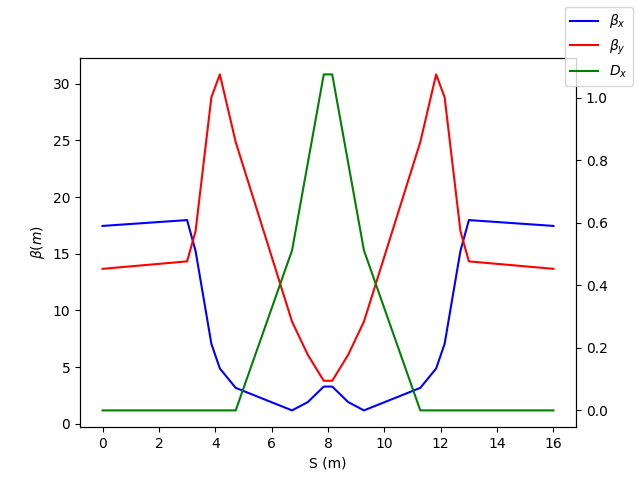

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tw['s'], tw['betx'], 'b', label = r'$\beta_x$')
ax.plot(tw['s'], tw['bety'], 'r', label = r'$\beta_y$')
ax.set(xlabel='S (m)', ylabel=r'$\beta (m)$')
ax2 = ax.twinx()

ax2.plot(tw['s'], tw['dx'], 'g', label = r'$D_x$')
fig.legend()

# Example 3 : Extend DBA cell with Drifts

One may extend a periodic cell by adding drifts on both sides, and using the doublets as matching quads to impose ax/y = 0 condition at both cell ends.


In [19]:
element_drift = {
    'd_ends' : xt.Drift(length = 2)
}

line2 = xt.Line(
    elements = {**{'m_start': xt.Marker()}, **element_drift, **line.element_refs._get_value(), **{'m_end': xt.Marker()}}, 
    element_names = ['m_start'] + list(element_drift.keys()) + list(line.element_names) +list(element_drift.keys())[::-1] + ['m_end']
)

line2.particle_ref = xt.Particles(mass0=xt.ELECTRON_MASS_EV,
                            gamma0=mad.sequence.machine.beam.gamma,
                                )
line2.build_tracker()

Found suitable prebuilt kernel `default_only_xtrack`.


In [20]:
line2.get_table().rows[:].show()

name                s element_type isthick compound_name
m_start             0 Marker         False              
d_ends              0 Drift           True              
machine$start       2 Marker         False              
od00                2 Drift           True              
qq1_entry           5 Marker         False              
qq1                 5 Quadrupole      True              
qq1_exit          5.3 Marker         False              
od0               5.3 Drift           True              
qq2_entry      5.8625 Marker         False              
qq2            5.8625 Quadrupole      True              
qq2_exit       6.1625 Marker         False              
od0:0          6.1625 Drift           True              
dain_entry      6.725 Marker         False              
dain_den        6.725 DipoleEdge     False              
dain            6.725 Bend            True              
dain_dex        8.725 DipoleEdge     False              
dain_exit       8.725 Marker   

### Match the alpha functions to zero at both cell ends

In [21]:
k1_init = line.element_refs['qq1'].k1._get_value() 
k2_init = line.element_refs['qq2'].k1._get_value()

print("k1_init = ", k1_init)
print("k2_init = ", k2_init)
line2.vars['kq_1'] = k1_init
line2.vars['kq_2'] = k2_init
line2.element_refs['qq1'].k1 = line2.vars['kq_1']
line2.element_refs['qq2'].k1 = line2.vars['kq_2']
line2.element_refs['qq1:0'].k1 = line2.vars['kq_1']
line2.element_refs['qq2:0'].k1 = line2.vars['kq_2']

k1_init =  1.837999606
k2_init =  -1.942926968


In [22]:
opt = line2.match(
    method='4d',
    assert_within_tol=False,
    vary=[
        xt.VaryList(['kq_1', 'kq_2'], step=1e-8, tag='quad'),
    ],
    targets = [
        xt.TargetSet(alfx=0, alfy=0, at = 'm_start', tol=1e-10, tag='alpha'),
        xt.TargetSet(alfx=0, alfy=0, at = 'm_end', tol=1e-10, tag='alpha'),
        xt.TargetSet(dpx=0, at = 'm_end', tol=1e-10, tag='alpha'),
        xt.Target(lambda tw: np.max(tw['bety']), xt.LessThan(35), tol=1e-6, tag='beta'),
        xt.Target(lambda tw: np.max(tw['betx']), xt.LessThan(35), tol=1e-6, tag='beta')
    ])

Found suitable prebuilt kernel `only_xtrack_frozen_energy`.
Matching: model call n. 4               



In [23]:
opt.target_status()
opt.vary_status()

Target status:                          
id state tag   tol_met      residue  current_val     target_val description                                 
 0 ON    alpha    True  3.85628e-11  3.85628e-11              0 ('alfx', 'm_start'), val=0, tol=1e-10, w ...
 1 ON    alpha    True            0            0              0 ('alfy', 'm_start'), val=0, tol=1e-10, w ...
 2 ON    alpha    True  2.31999e-12  2.31999e-12              0 ('alfx', 'm_end'), val=0, tol=1e-10, wei ...
 3 ON    alpha    True -7.67076e-15 -7.67076e-15              0 ('alfy', 'm_end'), val=0, tol=1e-10, wei ...
 4 ON    alpha    True -3.22612e-11 -3.22612e-11              0 ('dpx', 'm_end'), val=0, tol=1e-10, weig ...
 5 ON    beta     True            0      34.3868 LessThan(  35) callable, val=LessThan(  35), tol=1e-06, ...
 6 ON    beta     True            0      18.1664 LessThan(  35) callable, val=LessThan(  35), tol=1e-06, ...
Vary status:                 
id state tag  name lower_limit current_val upper_limit va

In [24]:
opt.log()

Table: 2 rows, 19 cols
iteration     penalty alpha tag tol_met target_active hit_limits vary_active vary_0   vary_1 ...
        0 1.37328e-09    -1     yynyyyy yyyyyyy       nn         yy           1.838 -1.94293
        1  3.8767e-10     0     yyyyyyy yyyyyyy       nn         yy           1.838 -1.94293

### Twiss

In [25]:
tw = line2.twiss(method='4d')

In [26]:
tw[['betx', 'bety', 'alfx', 'alfy', 'dx', 'dpx']]

TwissTable: 42 rows, 7 cols
name             betx    bety        alfx         alfy          dx          dpx
m_start       16.6664 14.0294 3.85628e-11            0 2.08706e-06  3.51352e-12
d_ends        16.6664 14.0294 3.85628e-11            0 2.08706e-06  3.51352e-12
machine$start 16.9064 14.3145   -0.120002    -0.142558 2.08706e-06  3.51352e-12
od00          16.9064 14.3145   -0.120002    -0.142558 2.08706e-06  3.51352e-12
qq1_entry     18.1664 15.8114   -0.300005    -0.356395 2.08707e-06  3.51352e-12
qq1           18.1664 15.8114   -0.300005    -0.356395 2.08707e-06  3.51352e-12
qq1_exit      15.4893 18.8193     8.72607     -10.2169 1.91682e-06 -1.11934e-06
od0           15.4893 18.8193     8.72607     -10.2169 1.91682e-06 -1.11934e-06
qq2_entry     7.24834 32.0852     5.92455     -13.3669 1.28719e-06 -1.11934e-06
qq2           7.24834 32.0852     5.92455     -13.3669 1.28719e-06 -1.11934e-06
qq2_exit      5.08256 34.3868     1.71069       6.1474  1.0557e-06 -4.46311e-07
od0:0       

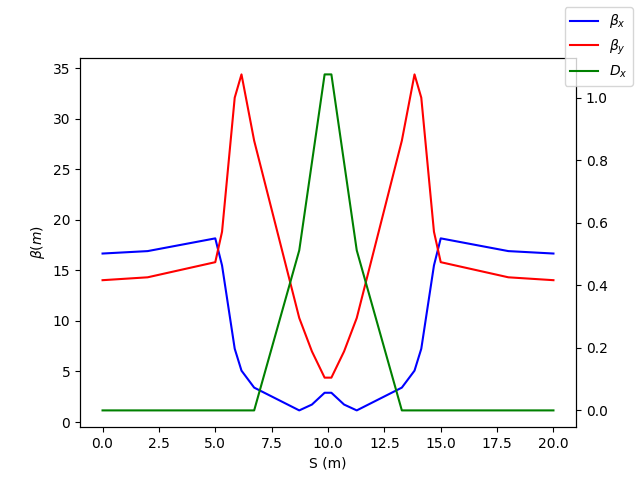

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tw['s'], tw['betx'], 'b', label = r'$\beta_x$')
ax.plot(tw['s'], tw['bety'], 'r', label = r'$\beta_y$')
ax.set(xlabel='S (m)', ylabel=r'$\beta (m)$')
ax2 = ax.twinx()

ax2.plot(tw['s'], tw['dx'], 'g', label = r'$D_x$')
fig.legend()

### Homework hint: Explore how far the cell length can be expanded... ? 

# Exemple 4: TME Cell 


A single bend flanked by a pair of mirror-symmetric doublets.

In [28]:
drift_length = 0.68
quadrupole_length = 0.3
k1_f = 1.5
k1_d = -1.5
dipole_length = 2
dipole_angle = 0.5235987756
dipole_bending_radius = dipole_length/dipole_angle

elements1 = {
    'm_start_tme_cell': xt.Marker(),
    'd1': xt.Drift(length=drift_length),
    'd2': xt.Drift(length=drift_length),
    'd3': xt.Drift(length=drift_length),
    'q1': xt.Quadrupole(length=quadrupole_length, k1=k1_f),
    'd4': xt.Drift(length=drift_length),
    'q2': xt.Quadrupole(length=quadrupole_length, k1=k1_d),
    'd5': xt.Drift(length=drift_length),
    'm_bend_1' : xt.Marker(),
    'b1': xt.Bend(length=dipole_length, k0 = 1/dipole_bending_radius, h = 1/dipole_bending_radius),
    'm_bend_2' : xt.Marker(),
    'd6': xt.Drift(length=drift_length),
    'q2:0': xt.Quadrupole(length=quadrupole_length, k1=k1_d),
    'd7': xt.Drift(length=drift_length),
    'q1:0': xt.Quadrupole(length=quadrupole_length, k1=k1_f),
    'd8': xt.Drift(length=drift_length),
    'd9': xt.Drift(length=drift_length),
    'd10': xt.Drift(length=drift_length),
    'm_end_tme_cell': xt.Marker(),
}

# Build the ring
line3 = xt.Line(
    elements=elements1,
    element_names=list(elements1.keys())
)
# Define reference particle
line3.particle_ref = xt.Particles(p0c=3e9, mass0=xt.ELECTRON_MASS_EV)

line3.build_tracker()

Found suitable prebuilt kernel `default_only_xtrack`.


### Machine Layout

In [29]:
sv = line3.survey()

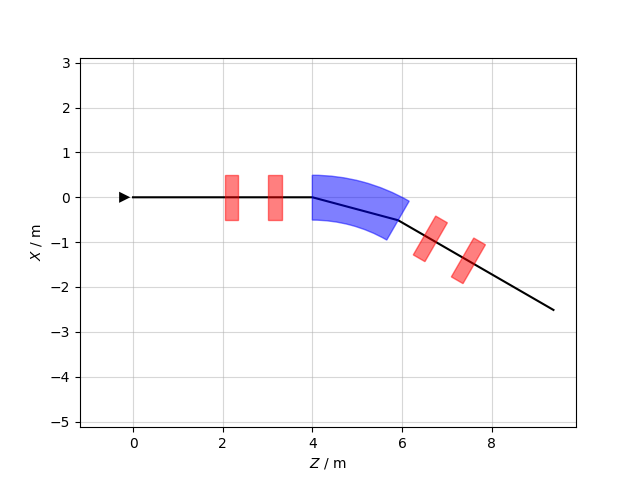

In [30]:
plot = xplt.FloorPlot(sv.rows[:], line3, 
                boxes={  
                    "q.": dict(color="red"), 
                    "b.": dict(color="blue"), 
                },
            )

In [31]:
k1_init = k1_f
k2_init = k1_d

print("k1_init = ", k1_init)
print("k2_init = ", k2_init)
line3.vars['kq_1'] = k1_init
line3.vars['kq_2'] = k2_init
line3.element_refs['q1'].k1 = line3.vars['kq_1']
line3.element_refs['q2'].k1 = line3.vars['kq_2']
line3.element_refs['q1:0'].k1 = line3.vars['kq_1']
line3.element_refs['q2:0'].k1 = line3.vars['kq_2']

k1_init =  1.5
k2_init =  -1.5


### Match the alpha functions to zero at both cell ends

In [32]:
opt = line3.match(
    method='4d',
    assert_within_tol=False,
    n_steps_max = 50,
    vary=[
        xt.VaryList(['kq_1', 'kq_2'], step=1e-6, tag='quad'),
    ],
    targets = [
        xt.TargetSet(alfx=0, alfy=0, at = 'm_start_tme_cell', tol=1e-10, tag='alpha'),
        xt.TargetSet(alfx=0, alfy=0, at = 'm_end_tme_cell', tol=1e-10, tag='alpha'),
        xt.TargetSet(dpx=0, at = 'm_end_tme_cell', tol=1e-10, tag='alpha'),
        xt.Target(lambda tw: np.max(tw['dx']), xt.LessThan(1.0), tol=1e-10, tag='beta')
    ])

Found suitable prebuilt kernel `only_xtrack_frozen_energy`.
Matching: model call n. 16               



In [33]:
opt.target_status()
opt.vary_status()

Target status:                           
id state tag   tol_met      residue  current_val     target_val description                                 
 0 ON    alpha    True -4.98035e-11 -4.98035e-11              0 ('alfx', 'm_start_tme_cell'), val=0, tol ...
 1 ON    alpha    True            0            0              0 ('alfy', 'm_start_tme_cell'), val=0, tol ...
 2 ON    alpha    True -4.30176e-11 -4.30176e-11              0 ('alfx', 'm_end_tme_cell'), val=0, tol=1 ...
 3 ON    alpha    True  -1.0083e-15  -1.0083e-15              0 ('alfy', 'm_end_tme_cell'), val=0, tol=1 ...
 4 ON    alpha    True  6.99249e-12  6.99249e-12              0 ('dpx', 'm_end_tme_cell'), val=0, tol=1e ...
 5 ON    beta     True            0            1 LessThan(   1) callable, val=LessThan(   1), tol=1e-10, ...
Vary status:                 
id state tag  name lower_limit current_val upper_limit val_at_iter_0  step weight
 0 ON    quad kq_1        None     1.66608        None           1.5 1e-06      1
 

In [34]:
opt.log()

Table: 5 rows, 18 cols
iteration     penalty alpha tag tol_met target_active hit_limits vary_active  vary_0   vary_1 ...
        0     0.28996    -1     yynyyn  yyyyyy        nn         yy              1.5     -1.5
        1   0.0536657     0     yyyyyn  yyyyyy        nn         yy          1.62478 -1.49858
        2  0.00250698     0     yynyyn  yyyyyy        nn         yy          1.66449 -1.50979
        3 5.60191e-06     0     yynyyn  yyyyyy        nn         yy          1.66607 -1.50928
        4 6.58133e-10     0     yyyyyy  yyyyyy        nn         yy          1.66608 -1.50928

### Twiss

In [35]:
tw = line3.twiss(method='4d')

In [36]:
tw[['betx', 'bety', 'alfx', 'alfy', 'dx', 'dpx']]

TwissTable: 20 rows, 7 cols
name                betx    bety         alfx        alfy       dx          dpx
m_start_tme_cell 12.2818 2.42094 -4.98035e-11           0        1 -2.69219e-13
d1               12.2818 2.42094 -4.98035e-11           0        1 -2.69219e-13
d2               12.3195 2.61194   -0.0553664   -0.280882        1 -2.69219e-13
d3               12.4324 3.18494    -0.110733   -0.561764        1 -2.69219e-13
q1               12.6207 4.13994    -0.166099   -0.842646        1 -2.69219e-13
d4               10.9179 5.38911      5.55537     -3.5273 0.925959    -0.487425
q2               4.71205 11.3396       3.5709     -5.2234  0.59451    -0.487425
d5               3.31448 12.9401      1.29671    0.132094 0.485786    -0.245587
m_bend_1         1.92504 12.7968     0.746581   0.0786275 0.318787    -0.245587
b1               1.92504 12.7968     0.746581   0.0786275 0.318787    -0.245587
m_bend_2         1.92504 12.7968    -0.746581  -0.0786275 0.318787     0.245587
d6          

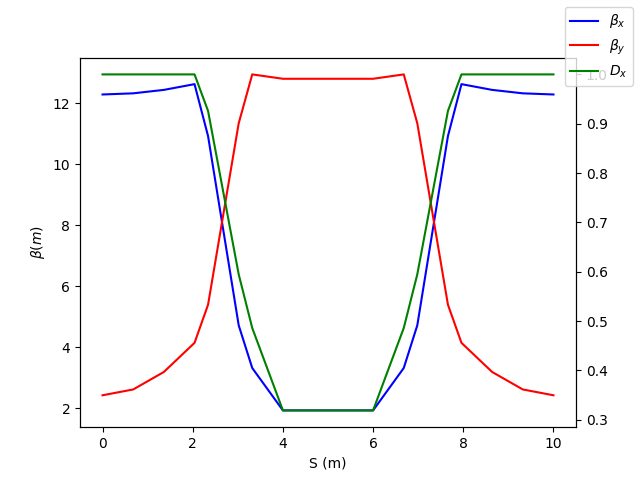

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tw['s'], tw['betx'], 'b', label = r'$\beta_x$')
ax.plot(tw['s'], tw['bety'], 'r', label = r'$\beta_y$')
ax.set(xlabel='S (m)', ylabel=r'$\beta (m)$')
ax2 = ax.twinx()

ax2.plot(tw['s'], tw['dx'], 'g', label = r'$D_x$')
fig.legend()

- Both the dispersion and the horizontal  beta are ‘squeezed’ at the bend by the doublets, which also provide hor/ver phase stability.
- The resulting lattice is periodic, but its is not an achromat  

# EXEMPLE 5: FMC (Flexible Momentum Compaction) Cell 

In [38]:
drift_length = 0.68
quadrupole_length = 0.3
dipole_length = 2

kf_q0 = 0.3
kf_q1 = 2.5 
kd_q2= -3.5 

dipole_angle = 0.5235987756
dipole_bending_radius = dipole_length/dipole_angle

elements1 = {
    'm_start_fmc_cell': xt.Marker(),
    'd1': xt.Drift(length=drift_length),
    'q0': xt.Quadrupole(length=quadrupole_length, k1=kf_q0),
    'd2': xt.Drift(length=drift_length),
    'd3': xt.Drift(length=drift_length),
    'm_bend_1' : xt.Marker(),
    'b1': xt.Bend(length=dipole_length, k0 = 1/dipole_bending_radius, h = 1/dipole_bending_radius),
    'd4': xt.Drift(length=drift_length),
    'd5': xt.Drift(length=drift_length),
    'q1': xt.Quadrupole(length=quadrupole_length, k1=kf_q1),
    'd6': xt.Drift(length=drift_length),
    'q2': xt.Quadrupole(length=quadrupole_length, k1=kd_q2),
    'd7': xt.Drift(length=drift_length),
    'q1:0': xt.Quadrupole(length=quadrupole_length, k1=kf_q1),
    'd8': xt.Drift(length=drift_length),
    'd9': xt.Drift(length=drift_length),
    'b2': xt.Bend(length=dipole_length, k0 = 1/dipole_bending_radius, h = 1/dipole_bending_radius),
    'm_bend_2' : xt.Marker(),
    'd10': xt.Drift(length=drift_length),
    'm_end_fmc_cell': xt.Marker(),
}

# Build the ring
line5 = xt.Line(
    elements=elements1,
    element_names=list(elements1.keys())
)
# Define reference particle
line5.particle_ref = xt.Particles(p0c=3e9, mass0=xt.ELECTRON_MASS_EV)

line5.build_tracker()

Found suitable prebuilt kernel `default_only_xtrack`.


### Machine Layout

In [39]:
sv = line5.survey()

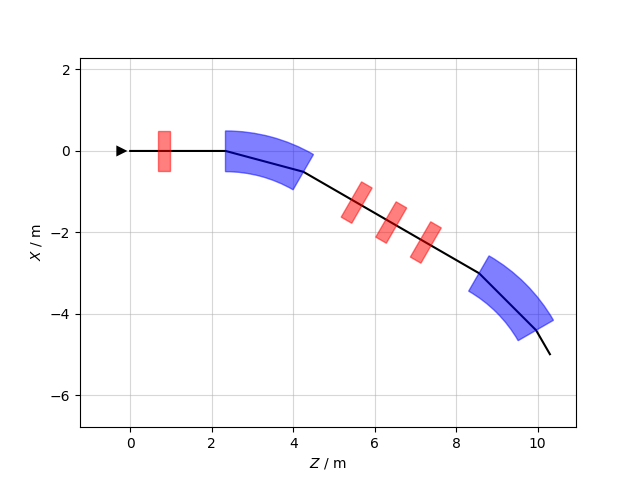

In [40]:
plot = xplt.FloorPlot(sv.rows[:], line5, 
                boxes={  
                    "q.": dict(color="red"), 
                    "b.": dict(color="blue"), 
                },
            )

## Matching

In [41]:
kq0_init = line5.element_refs['q0'].k1._get_value()
kq1_init = line5.element_refs['q1'].k1._get_value()
kq2_init = line5.element_refs['q2'].k1._get_value()

In [42]:
line5.vars['kq0'] = 0.3
line5.vars['kq1'] = 2.5 
line5.vars['kq2'] = -3.5 
print(kq0_init, kq1_init, kq2_init)

0.3 2.5 -3.5


In [43]:
line5.element_refs['q0'].k1=line5.vars['kq0']
line5.element_refs['q1'].k1=line5.vars['kq1']
line5.element_refs['q1:0'].k1=line5.vars['kq1']
line5.element_refs['q2'].k1=line5.vars['kq2']

In [44]:
opt = line5.match(
    method='4d',
    vary=[
        xt.VaryList(['kq0', 'kq1', 'kq2'], step=1e-8, tag='quad'),
    ],
    targets = [
        xt.Target(lambda tw: tw['dx', 'm_bend_1'], xt.LessThan(0.0), tol=1e-10, tag='dispersion'),
    ])

Found suitable prebuilt kernel `only_xtrack_frozen_energy`.
Matching: model call n. 20               



In [45]:
opt.target_status()
opt.vary_status()

Target status:                           
id state tag        tol_met residue  current_val     target_val description                                 
 0 ON    dispersion    True       0 -2.20838e-13 LessThan(   0) callable, val=LessThan(   0), tol=1e-10, ...
Vary status:                 
id state tag  name lower_limit current_val upper_limit val_at_iter_0  step weight
 0 ON    quad kq0         None    0.298446        None           0.3 1e-08      1
 1 ON    quad kq1         None     2.60431        None           2.5 1e-08      1
 2 ON    quad kq2         None    -3.47349        None          -3.5 1e-08      1


In [46]:
opt.log()[['penalty', 'vary_0', 'vary_1']]

Table: 5 rows, 4 cols
iteration     penalty   vary_0  vary_1
        0    0.108911      0.3     2.5
        1  0.00468283  0.29845 2.59963
        2 1.61098e-05 0.298446  2.6043
        3 1.60917e-08 0.298446 2.60431
        4           0 0.298446 2.60431

### Twiss

In [49]:
tw = line5.twiss(method='4d')

In [50]:
tw[['betx', 'bety', 'dx']]

TwissTable: 21 rows, 4 cols
name                 betx    bety           dx
m_start_fmc_cell  11.9988 3.37194  1.38138e-11
d1                11.9988 3.37194  1.38138e-11
q0                12.7106 2.96128  1.00994e-11
d2                12.7106 2.96128  8.33271e-12
d3                11.9988 3.37194  4.05593e-12
m_bend_1          11.3823 4.10539 -2.20838e-13
b1                11.3823 4.10539 -2.20838e-13
d4                7.52995 8.13343     0.511745
d5                5.89276  10.139     0.851745
q1                 4.5952 12.4675      1.19175
d6                 3.2069 16.9375        1.199
q2               0.382248 41.8153     0.891217
d7               0.382248 41.8153     0.891217
q1:0               3.2069 16.9375        1.199
d8                 4.5952 12.4675      1.19175
d9                5.89276  10.139     0.851745
b2                7.52995 8.13343     0.511745
m_bend_2          11.3823 4.10539   4.7973e-11
d10               11.3823 4.10539   4.7973e-11
m_end_fmc_cell    11.9988 3.3719

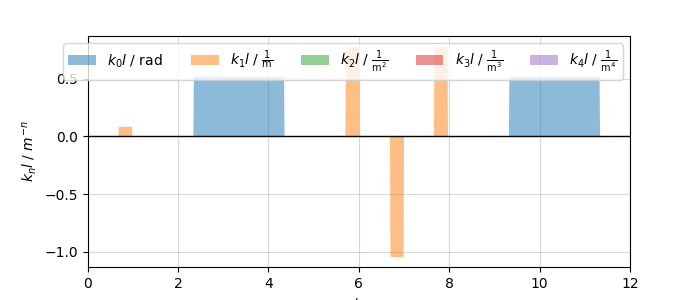

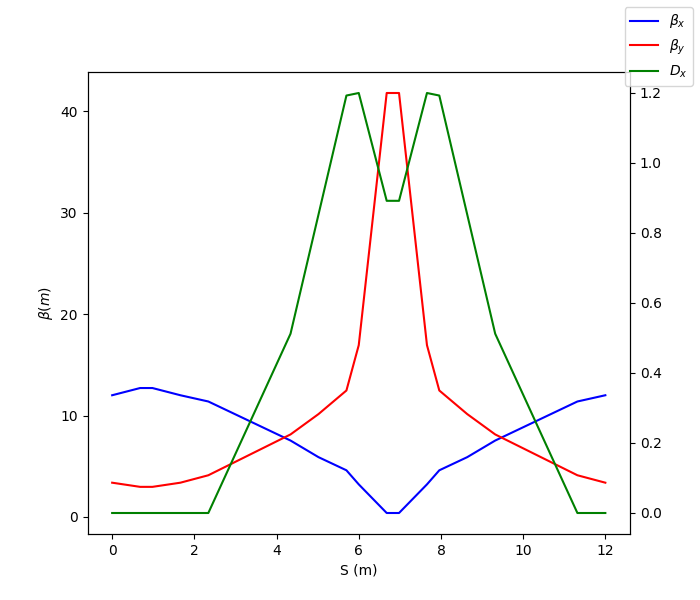

In [51]:
xplt.KnlPlot(line=line5, figsize=(7, 3),)
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)
ax.plot(tw['s'], tw['betx'], 'b', label = r'$\beta_x$')
ax.plot(tw['s'], tw['bety'], 'r', label = r'$\beta_y$')
ax.set(xlabel='S (m)', ylabel=r'$\beta (m)$')
ax2 = ax.twinx()

ax2.plot(tw['s'], tw['dx'], 'g', label = r'$D_x$')
fig.legend()

In [52]:
tw.momentum_compaction_factor

0.015023446991340183

#### Dispersion suppressed by a quad triplet flanked by a pair of bends. Additional singlet provides hor/ver phase stability. The resulting cell is periodic.

# EXEMPLE 6: FMC Cell 

- Adjusting both the quad triplet and the singlet in a periodic cell one can ‘drive’ the dispersion negative, which results in a negative momentum compaction, M56.

- This cell architecture supports a vast range of M56 values, hence its name, FMC. It can also be tuned to the isochronous condition, M56 = 0. 


In [53]:
line5.get_table().rows[:].show()

name                 s element_type isthick compound_name
m_start_fmc_cell     0 Marker         False              
d1                   0 Drift           True              
q0                0.68 Quadrupole      True              
d2                0.98 Drift           True              
d3                1.66 Drift           True              
m_bend_1          2.34 Marker         False              
b1                2.34 Bend            True              
d4                4.34 Drift           True              
d5                5.02 Drift           True              
q1                 5.7 Quadrupole      True              
d6                   6 Drift           True              
q2                6.68 Quadrupole      True              
d7                6.98 Drift           True              
q1:0              7.66 Quadrupole      True              
d8                7.96 Drift           True              
d9                8.64 Drift           True              
b2            

In [54]:
kq0_init = line5.element_refs['q0'].k1._get_value()
kq1_init = line5.element_refs['q1'].k1._get_value()
kq2_init = line5.element_refs['q2'].k1._get_value()

In [55]:
line5.vars['kq0'] = kq0_init 
line5.vars['kq1'] = kq1_init 
line5.vars['kq2'] = kq2_init 
print(kq0_init, kq1_init, kq2_init)

0.2984455282994546 2.604311823077211 -3.473490674367699


In [56]:
line5.element_refs['q0'].k1=line5.vars['kq0']
line5.element_refs['q1'].k1=line5.vars['kq1']
line5.element_refs['q1:0'].k1=line5.vars['kq1']
line5.element_refs['q2'].k1=line5.vars['kq2']

### Match the quad triplet and the singlet to drive the dispersion negative

In [57]:
line5.get_table().rows[:].show()

name                 s element_type isthick compound_name
m_start_fmc_cell     0 Marker         False              
d1                   0 Drift           True              
q0                0.68 Quadrupole      True              
d2                0.98 Drift           True              
d3                1.66 Drift           True              
m_bend_1          2.34 Marker         False              
b1                2.34 Bend            True              
d4                4.34 Drift           True              
d5                5.02 Drift           True              
q1                 5.7 Quadrupole      True              
d6                   6 Drift           True              
q2                6.68 Quadrupole      True              
d7                6.98 Drift           True              
q1:0              7.66 Quadrupole      True              
d8                7.96 Drift           True              
d9                8.64 Drift           True              
b2            

In [58]:
opt = line5.match(
    method='4d',
    assert_within_tol=False,
    vary=[
        xt.VaryList(['kq0', 'kq1', 'kq2'], step=1e-8, tag='quad'),
    ],
    targets = [
        xt.Target(lambda tw: tw['dx', 'm_bend_1'], xt.LessThan(-0.45), tol=1e-10, tag='dispersion'),
        xt.Target(lambda tw: np.max(tw['betx']), xt.LessThan(30.0), tol=1e-10, tag='beta'),
        xt.Target(lambda tw: np.max(tw['bety']), xt.LessThan(30.0), tol=1e-10, tag='beta')
    ])

/Users/marionvanwelde/.pyenv/versions/py38/lib/python3.8/site-packages/xtrack/linear_normal_form.py:184: RuntimeWarning: invalid value encountered in sqrt
  n2 = 1./np.sqrt(np.matmul(np.matmul(a2, S), b2))


/Users/marionvanwelde/.pyenv/versions/py38/lib/python3.8/site-packages/xtrack/linear_normal_form.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  n1 = 1./np.sqrt(np.matmul(np.matmul(a1, S), b1))
/Users/marionvanwelde/.pyenv/versions/py38/lib/python3.8/site-packages/xtrack/linear_normal_form.py:187: RuntimeWarning: invalid value encountered in multiply
  a1 *= n1
/Users/marionvanwelde/.pyenv/versions/py38/lib/python3.8/site-packages/xtrack/linear_normal_form.py:191: RuntimeWarning: invalid value encountered in multiply
  b1 *= n1


Matching: model call n. 54               



In [59]:
opt.target_status()
opt.vary_status()

Target status:                           
id state tag        tol_met      residue current_val      target_val description                                 
 0 ON    dispersion    True            0       -0.45 LessThan(-0.45) callable, val=LessThan(-0.45), tol=1e-10 ...
 1 ON    beta          True            0     8.00542  LessThan(  30) callable, val=LessThan(  30), tol=1e-10, ...
 2 ON    beta          True -2.38387e-12          30  LessThan(  30) callable, val=LessThan(  30), tol=1e-10, ...
Vary status:                 
id state tag  name lower_limit current_val upper_limit val_at_iter_0  step weight
 0 ON    quad kq0         None   -0.287711        None      0.298446 1e-08      1
 1 ON    quad kq1         None     3.43284        None       2.60431 1e-08      1
 2 ON    quad kq2         None    -3.81989        None      -3.47349 1e-08      1


In [60]:
opt.log()[['penalty', 'vary_0', 'vary_1', 'vary_2']]

Table: 10 rows, 5 cols
iteration     penalty     vary_0  vary_1   vary_2
        0     11.8239   0.298446 2.60431 -3.47349
        1     10.7361   0.313174   2.735  -3.5157
        2     10.5727   0.310116 2.75731 -3.50506
        3     10.0419   0.154788 2.85504 -3.49284
        4     7.53555 -0.0517246 3.28514 -3.82737
        5     6.14074 -0.0604207 3.32025 -3.78731
        6  0.00291895   -0.28917 3.42679 -3.82137
        7  0.00181237  -0.287648 3.43282  -3.8199
        8 8.11388e-08  -0.287711 3.43284 -3.81989
        9 2.38387e-12  -0.287711 3.43284 -3.81989

In [61]:
tw = line5.twiss(method='4d')
tw.momentum_compaction_factor

-0.024037932606061525

### Twiss

In [62]:
tw = line5.twiss(method='4d')

In [63]:
tw

TwissTable: 21 rows, 47 cols
name                 s            x           px y py         zeta delta ptau     betx    bety ...
m_start_fmc_cell     0            0            0 0  0            0     0    0  6.86107 6.64854
d1                   0            0            0 0  0            0     0    0  6.86107 6.64854
q0                0.68            0            0 0  0            0     0    0   6.3765 6.95688
d2                0.98            0            0 0  0            0     0    0   6.3765 6.95688
d3                1.66            0            0 0  0            0     0    0  6.86107 6.64854
m_bend_1          2.34            0            0 0  0            0     0    0  7.50356 6.48351
b1                2.34            0            0 0  0            0     0    0  7.50356 6.48351
d4                4.34 -1.42733e-12 -1.39458e-12 0  0 -3.41521e-12     0    0  8.00542 6.82875
d5                5.02 -2.37564e-12 -1.39458e-12 0  0 -3.41521e-12     0    0  7.65651 7.22854
q1               

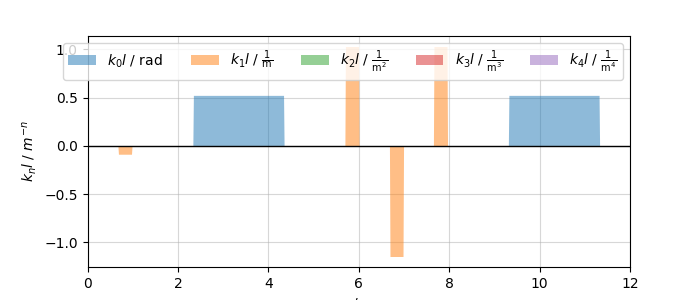

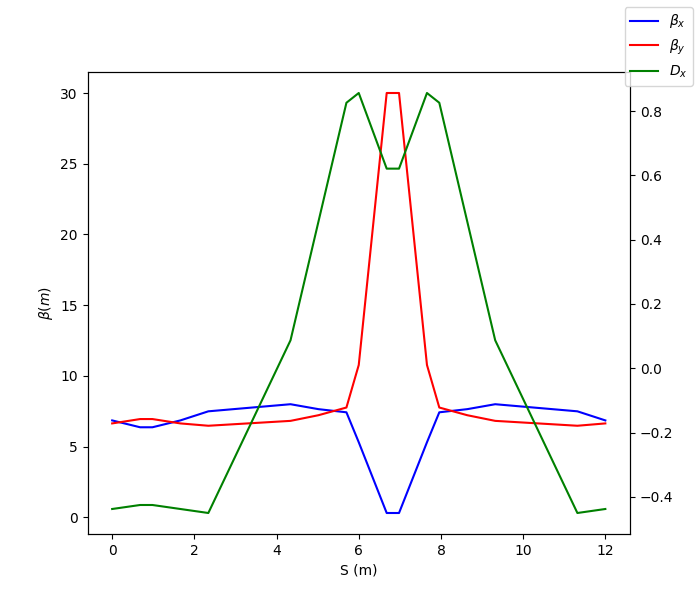

In [64]:
xplt.KnlPlot(line=line5, figsize=(7, 3),)
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)
ax.plot(tw['s'], tw['betx'], 'b', label = r'$\beta_x$')
ax.plot(tw['s'], tw['bety'], 'r', label = r'$\beta_y$')
ax.set(xlabel='S (m)', ylabel=r'$\beta (m)$')
ax2 = ax.twinx()

ax2.plot(tw['s'], tw['dx'], 'g', label = r'$D_x$')
fig.legend()